In [20]:
import os
import ipywidgets as widgets
import numpy as np
import pandas as pd
import scipy.sparse
from IPython.display import display
from ipywidgets import interact
from matplotlib import pyplot as plt
from utils.metrics.metric import evaluate_classifications, evaluate_probabilities
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preparation

First split the orig_dataset into train and test set, then we need to
pre-process the transcript data

This includes, cleaning text, stemming and lemmatization

In [21]:
from prepare_data import prepare_original_data

# YOU MAY NEED TO SET THE LOCATION OF THE DATASET IN oneinamillion/resources.py.
orig_dataset, mult_lbl_enc, y_hot = prepare_original_data()

The current IDs only have record documents.
['011119' '020105' '030501' '030509' '030510' '050609' '050717' '050719'
 '071010' '071211' '081310' '081608' '081610' '091410' '091411' '091416'
 '101705' '101707' '111906' '111908' '112004' '122110']


RDSF base directory located at /user/work/zu20361/PCC/


The current IDs only have transcript documents.
['-081308' '010103' '010105' '020107' '030501(p.2)' '030501(p1)'
 '030509(p.1)' '030509(p.2)' '030510 (p.1)' '030510 (p.2)' '040417'
 '050605' '050609a' '050717 (Dr reads wrong number)' '060806' '060811'
 '060812' '060906' '071002' '071010(a)' '071012' '071211 (Part 1 of 2)'
 '071211 (Part 2 of 2)' '081310(b)' '081310(c)' '081310a' '081601'
 '081606' '081608 (1 of 2)' '081608 (2 of 2)' '091402' '091404' '091405'
 '091410 & 091411' '091503' '101705 and 101707' '101801' '111906 (2of2)'
 '111906(1 of 2)' '112002' '112004 & 1112005' '112014' '200105' '50719']


16 classification categories: ['A' 'B' 'D' 'F' 'H' 'K' 'L' 'N' 'P' 'R' 'S' 'T' 'U' 'W' 'X' 'Y']


## Train test Split

In [22]:
from skmultilearn.model_selection import iterative_train_test_split

X = np.arange(orig_dataset['index'].shape[0]).reshape((-1, 1))

X_train, y_train, X_test, y_test = iterative_train_test_split(X, y_hot, test_size=0.2)

train_set = orig_dataset.iloc[X_train.flatten()]
test_set = orig_dataset.iloc[X_test.flatten()]
train_set.head()

,index,record_id,icpc_codes,pt_records,transcript__start_date,transcript__duration,transcript__conversation,codes,transcript__conversation_clean,transcript__conversation_both,transcript__conversation_gp,transcript__conversation_patient
0,0,30301,"['U99', 'B80']","[{'date': datetime.datetime(2014, 12, 23, 0, 0...",2014-09-29 09:03:52,0:13:19,"[('info', 'Record'), ('Doc', '. Do have a seat...","[U, B]","[[info, record], [Doc, . seat.], [Pat, asked s...",". seat. asked see me, believe, blood test, it,...",". seat. blood test, it, think ___, it? tell me...","asked see me, believe, right, yes. yes. used g..."
1,1,40416,"['S96', 'P76']","[{'date': datetime.datetime(2014, 12, 8, 0, 0)...",2014-10-09 09:27:51,0:15:25,"[('GP', 'Can I just take your…'), ('Patient', ...","[S, P]","[[GP, take your…], [Patient, yes, sorry. was, ...","take your… yes, sorry. was, like, thing there....","take your… 040416. right, , you’ve got piece p...","yes, sorry. was, like, thing there. yes. okay-..."
2,2,20106,"['Y07', 'T91', 'A91']","[{'date': datetime.datetime(2014, 10, 2, 0, 0)...",2014-08-03 10:17:18,0:13:18,"[('Doc', 'This is patient 06.'), ('Pat', '(Kno...","[Y, T, A]","[[Doc, patient 06.], [Pat, (knocks).], [Doc, c...","patient 06. (knocks). come in. hi, come in, se...","patient 06. come in. hi, come in, seat. yes, g...","(knocks). hello, doctor, you? ___ yes. i’ve st..."
4,4,11107,"['L99', 'W11']","[{'date': datetime.datetime(2014, 12, 17, 0, 0...",2014-12-08 11:22:27,0:05:39,"[('Doc', 'Hi, I’m Dr Name'), ('Pat', 'Hello.')...","[L, W]","[[Doc, hi, i’m dr name], [Pat, hello.], [Doc, ...","hi, i’m dr name hello. brilliant, 011107. righ...","hi, i’m dr name brilliant, 011107. right, name...","hello. couple things, one thing need repeat pr..."
5,5,71014,['L08'],"[{'date': datetime.datetime(2015, 2, 17, 0, 0)...",2015-01-29 17:27:42,0:05:43,"[('GP', ""Good. So 071014, that's your number. ...",[L],"[[GP, good. 071014, that's number. i'll write ...","good. 071014, that's number. i'll write down. ...","good. 071014, that's number. i'll write down. ...","___ long, bubba. sorry. partner come give u li..."


In [5]:
labels = {}
for codes in orig_dataset['codes']:
    #print(codes)
    for code in codes:
        if code not in labels:
            labels[code] = 0
            
        labels[code] += 1
        
labels

{'K': 29,
 'P': 48,
 'R': 35,
 'U': 20,
 'H': 10,
 'D': 38,
 'Y': 8,
 'L': 68,
 'B': 7,
 'S': 32,
 'X': 11,
 'T': 17,
 'N': 14,
 'W': 12,
 'F': 3,
 'A': 17}

## ICPC descriptions

In [23]:
selected_mode = None
modes = ['ICPC only', 'CKS only', 'ICPC and CKS']
def control_description(mode=modes[0]):
    global selected_mode
    selected_mode = mode

interact(control_description, mode=modes)

interactive(children=(Dropdown(description='mode', options=('ICPC only', 'CKS only', 'ICPC and CKS'), value='I…

<function __main__.control_description(mode='ICPC only')>

In [24]:
# interaction donot work for me
selected_mode = 'CKS only'

In [25]:
from prepare_data import load_descriptions
description_corpus = load_descriptions(selected_mode)

In [9]:
description_corpus

A    pain general/multiple site  chronic general pa...
B    lymph gland(s) enlarged/painful  lymphadenopat...
D    abdominal pain/cramps general  abdominal colic...
F    eye pain   red eye  bloodshot/inflamed eye eye...
H    ear pain/earache   hearing complaint  auditory...
K    heart pain  pain attributed heart pressure/tig...
L    neck symptom/complaint  pain attributed cervic...
N    headache  post-traumatic headache pain face   ...
P    feeling anxious/nervous/tense feeling reported...
R    pain respiratory system  painful respiration; ...
S    pain/tenderness skin  burning sensation; painf...
T    excessive thirst  polydipsia excessive appetit...
U    dysuria/painful urination  burning urination u...
W    question pregnancy  delayed menstruation; symp...
X    genital pain female  pelvic pain; vulval pain ...
Y    pain penis   pain testis/scrotum  pain pelvis;...
Name: keyword, dtype: object

## Bag of words classifiers

**Tf-idf from ICPC codes**

- extract keyword/ keyphrases from ICPC code descriptions
 - use three columns (inclusion/ preferred and criteria)

- OR, with TF-iDF, assign a score to every word (or bigram) in the utterance,
filter those with only high scores

- For each utterance in a transcript, count the number of keyword or phrase matches for each ICPC code.
- If number of matches > threshold, assign ICPC code

One might want to modify the list of stopwords to eliminate from the tf-idf vocabulary,
or might impose a limit of the number of features to reduce unwanted words/ bi-grams.

In [26]:
from utils.stopwords import get_medical_stopwords, get_custom_stopwords, get_english_stopwords
medical_stopwords = get_medical_stopwords()
custom_stopwords = get_custom_stopwords()
english_stopwords = get_english_stopwords()

use_med, use_cus, use_eng = False, False, False
stopwords = []

def update_stopwords():
    global stopwords
    stopwords = []
    if use_med:
        stopwords += medical_stopwords
    if use_cus:
        stopwords += custom_stopwords
    if use_eng:
        stopwords += english_stopwords
    # display(f"number of stopwords: {len(stopwords)}")

def set_stopwords(m,c,e):
    global use_med, use_cus, use_eng
    use_med = m
    use_cus = c
    use_eng = e
    update_stopwords()

interact(set_stopwords, m=True, c=True, e=False)

interactive(children=(Checkbox(value=True, description='m'), Checkbox(value=True, description='c'), Checkbox(v…

<function __main__.set_stopwords(m, c, e)>

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_description_vectors(description_corpus, stopwords):
    max_features=5000

    text_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords, max_features=max_features)
    description_vec = text_vectorizer.fit_transform(description_corpus)
    # print(f"icpc description bag-of-word matrix shape: {description_vec.shape}")
    vec_vocab = text_vectorizer.vocabulary_ # dictionary that contain the BOW tokens

    # print(f"bag-of-word tokens: {', '.join(list(vec_vocab.keys())[:5])}...")
    # print(f"vocabulary size: {len(vec_vocab)}")

    return description_vec, text_vectorizer

description_vec, text_vectorizer = get_description_vectors(description_corpus, stopwords)

## Models
### NB classifier

In [30]:
from sklearn.naive_bayes import MultinomialNB
def run_multiclass_naive_bayes(X_train, y_train, X_test):
    clf = MultinomialNB(alpha=0.001, fit_prior=False)
    clf.fit(X_train, np.argmax(y_train, 1))

    y_pred_probs = clf.predict_proba(X_test)

    y_pred_mat = y_pred_probs > 0.1

    return y_pred_mat, y_pred_probs

### SVM classifier

In [31]:
from sklearn.svm import SVC

def run_svm(X_train, y_train, X_test):
    nclasses = y_train.shape[1]

    clf = SVC(kernel='rbf', C=2)

    clf.fit(X_train, np.argmax(y_train, 1))

    y_pred = clf.predict(X_test)
    y_pred_probs = clf.decision_function(X_test)

    y_pred_mat = np.zeros((y_pred.shape[0], nclasses))
    y_pred_mat[np.arange(y_pred.shape[0]), y_pred] = 1

    return y_pred_mat, y_pred_probs

## Distant Supervison

In [29]:
key = 'transcript__conversation_both'
# key = 'transcript__conversation_gp'
# key = 'transcript__conversation_patient'
y = [[i] for i in description_corpus.index]

y_desc = mult_lbl_enc.fit_transform(y)

transcript_data = orig_dataset[key]
transcript_test = text_vectorizer.transform(transcript_data)

### Coarse-grained classification
#### NB Classifier

In [18]:
y_pred_mat, y_pred_probs = run_multiclass_naive_bayes(description_vec, y_desc, transcript_test)
print(evaluate_classifications(y_hot, y_pred_mat, mult_lbl_enc.classes_))
print(evaluate_probabilities(y_hot, y_pred_probs))

0.34045860347828805
0.780024367418094


#### SVM Classifier

In [20]:
y_pred_mat, y_pred_probs= run_svm(description_vec, y_desc, transcript_test)
print(evaluate_classifications(y_hot, y_pred_mat, mult_lbl_enc.classes_))
print(evaluate_probabilities(y_hot, y_pred_probs))

0.3619733144442262
0.8335111641319247


### Fine-grained classification

In [9]:
import json
from oneinamillion.resources import DL_DATA, ICPC2CKS, CKS_DESC, PCC_CODES_DIR, PCC_CKS_DIR
from sklearn.preprocessing import MultiLabelBinarizer
from utils.utils import prediction_cks2icpc

In [48]:
# load topics trained in DL methods to keep consitent
topics_file = os.path.join(DL_DATA, 'fg_label2id.json')
with open(topics_file, 'r') as f:
    selected_topics = json.load(f)
# load health topics
health_topics = pd.read_csv(os.path.join(PCC_CKS_DIR, CKS_DESC), index_col=0)
health_topics = health_topics.loc[selected_topics]

description_vec, text_vectorizer = get_description_vectors(health_topics['topics'], stopwords)
# obtain labels
mult_lbl_enc2 = MultiLabelBinarizer()
y = [[i] for i in health_topics.index]
y_desc = mult_lbl_enc2.fit_transform(y)

# obtain test data
transcript_test = text_vectorizer.transform(transcript_data)

#### NB Classifier 

In [56]:
y_pred_mat, y_pred_probs = run_multiclass_naive_bayes(description_vec, y_desc, transcript_test)
# convert label_id to class names
pred_labels = mult_lbl_enc2.inverse_transform(y_pred_mat)

map_file = os.path.join(PCC_CKS_DIR, ICPC2CKS)
# create a fake label2name
label2name = {label:label for label in mult_lbl_enc.classes_}
# map cks to icpc
mapped_predictions = prediction_cks2icpc(map_file, pred_labels, label2name)
predictions = mult_lbl_enc.transform(mapped_predictions)
print(evaluate_classifications(y_hot, predictions, mult_lbl_enc.classes_))

2.3201562287071104e-01


In [62]:
y_pred_mat, y_pred_probs = run_svm(description_vec, y_desc, transcript_test)
pred_labels = mult_lbl_enc2.inverse_transform(y_pred_mat)
map_file = os.path.join(PCC_CKS_DIR, ICPC2CKS)
# create a fake label2name
label2name = {label:label for label in mult_lbl_enc.classes_}
# map cks to icpc
mapped_predictions = prediction_cks2icpc(map_file, pred_labels, label2name)
predictions = mult_lbl_enc.transform(mapped_predictions)
print(evaluate_classifications(y_hot, predictions, mult_lbl_enc.classes_))

0.35516238803557787


Text(0.5, 1.0, 'bag-of-words Vector')

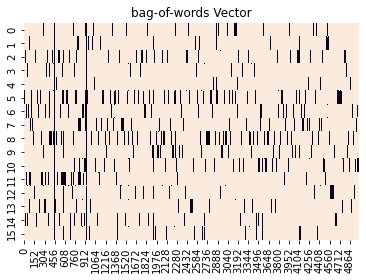

In [12]:
import seaborn as sns
sns.heatmap(description_vec.todense()==0, vmin=0, vmax=1, cbar=False).set_title('bag-of-words Vector')

In [13]:
# from wordcloud import WordCloud
# test_vec = description_vec[1].todense()
# col_names = np.array(text_vectorizer.get_feature_names())
# test = pd.DataFrame(test_vec, columns=col_names).T.to_dict()[0]
# print(test)
# word_cloud = WordCloud(background_color="white").generate_from_frequencies(test)
# plt.imshow(word_cloud)

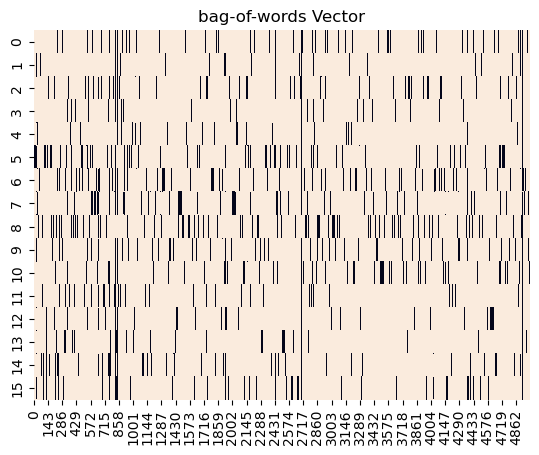

interactive(children=(Dropdown(description='cat', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', '…

<function __main__.plot_explain_category(cat: str)>

In [14]:
from wordcloud import WordCloud

# Explain a category

lookup = [x for _,x in sorted(zip(text_vectorizer.vocabulary_.values(), text_vectorizer.vocabulary_.keys()))]
features_arr = np.array(text_vectorizer.get_feature_names())

def explain_bow_vector(vec: scipy.sparse.csr.csr_matrix, ax=plt):
    # _, idxs = scipy.sparse.csr_matrix.nonzero(vec)
    # words = [lookup[k] for k in idxs]
    # word_cloud = WordCloud().generate(' '.join(words))
    test = pd.DataFrame(vec.todense(), columns=features_arr).T.to_dict()[0]
    word_cloud = WordCloud(background_color="white").generate_from_frequencies(test)
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis("off")

def explain_category(cat:str, ax=plt):
    target = list(mult_lbl_enc.classes_).index(cat)
    target = description_vec[target]
    explain_bow_vector(target, ax=ax)

def plot_explain_category(cat:str):
    explain_category(cat)

interact(plot_explain_category, cat=mult_lbl_enc.classes_)

In [15]:
key = 'transcript__conversation_both'
# key = 'transcript__conversation_gp'
# key = 'transcript__conversation_patient'

X_train = text_vectorizer.transform(train_set[key])
X_test = text_vectorizer.transform(test_set[key])

Text(0.5, 1.0, 'Train set bag-of-words matrix')

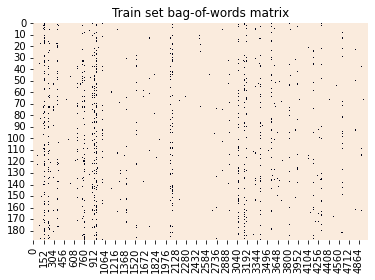

In [16]:
# import seaborn as sns
sns.heatmap(X_train.todense()==0, vmin=0, vmax=1, cbar=False).set_title('Train set bag-of-words matrix')

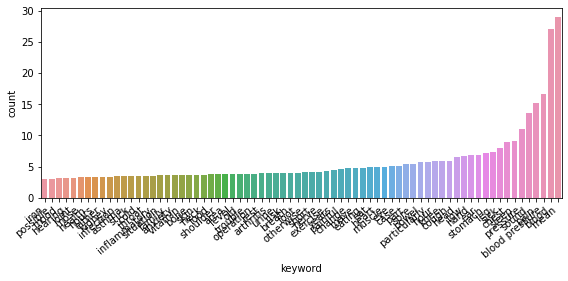

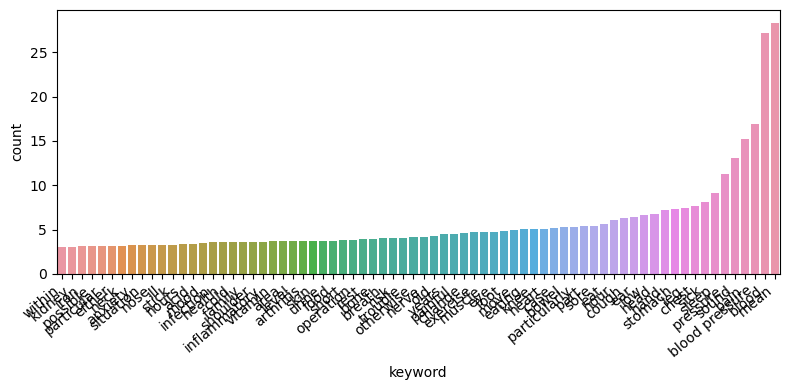

['within', 'kidney', 'iron', 'possible', 'particular', 'either', 'neck', 'anxiety', 'situation', 'nose', 'ill', 'stick', 'hours', 'acid', 'mood', 'infection', 'health', 'cold', 'family', 'shoulder', 'inflammatory', 'vitamin', 'area', 'level', 'arthritis', 'skin', 'urine', 'food', 'short', 'operation', 'rest', 'bone', 'breath', 'risk', 'trouble', 'otherwise', 'nerve', 'old', 'years', 'painful', 'change', 'exercise', 'muscle', 'eye', 'foot', 'move', 'eating', 'knee', 'heart', 'case', 'bowel', 'particularly', 'part', 'sore', 'eat', 'hour', 'cough', 'ear', 'low', 'head', 'hand', 'stomach', 'leg', 'chest', 'sick', 'sleep', 'pressure', 'sound', 'pain', 'blood pressure', 'blood', 'mean']


In [17]:
keyword_dist_over_train = np.array(X_train.sum(axis=0)).flatten()

def show_common_keywords(threshold:int = 3):
    frequent_words = [[k,n] for k,n in zip(lookup, keyword_dist_over_train) if n > threshold]
    frequent_words_df = pd.DataFrame(frequent_words,columns=['keyword', 'count']).sort_values('count')

    plt.figure(figsize=(8,4))
    ax = sns.barplot(x='keyword', y='count', data=frequent_words_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

    print([k._text for k in ax.get_xticklabels()])

show_common_keywords()

### Nearest Centroid classifier

In [19]:
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier


def run_nearest_centroid(description_vec, mult_lbl_enc, X_test):
    nc_clf = NearestCentroid(metric='euclidean')
    nc_clf.fit(description_vec, mult_lbl_enc.classes_)
    y_pred = nc_clf.predict(X_test)

    y_pred_mat = np.matrix(mult_lbl_enc.transform(y_pred))

    return y_pred_mat

y_pred_mat = run_nearest_centroid(description_vec, mult_lbl_enc, X_train)
print(evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_))

def run_distance_classifier(description_vec, X_train, y_train, X_test):

    kn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine')
    kn_clf.fit(description_vec, mult_lbl_enc.classes_)

    max_acc = 0
    threshold = 0.8
    best_threshold = 0
    while threshold <= 1:
        y_dists, y_pred = kn_clf.kneighbors(X_train, 3)
        y_tr_pred = np.zeros((X_train.shape[0], y_train.shape[1]))
        for i in range(y_tr_pred.shape[0]):
            y_tr_pred[i, y_pred[i]] = (y_dists[i] < threshold).astype(int)

        acc = f1_score(y_train, y_tr_pred, average='micro')
        # print(f'F1: {acc}, threshold: {threshold}')

        if acc > max_acc:
            max_acc = acc
            best_threshold = threshold
        threshold += 0.01

    # print('predicting...')
    y_dists, y_pred = kn_clf.kneighbors(X_test, 3)
    y_pred_mat = np.zeros((X_test.shape[0], y_train.shape[1]))
    for i in range(y_pred.shape[0]):
        y_pred_mat[i, y_pred[i][0]] = (y_dists[i][0] < best_threshold).astype(int)

    # dists = cosine_similarity(X_train, description_vec)
    # print(dists)

    #
    # dists = cosine_similarity(X_test, description_vec)
    # y_pred_mat = dists > best_threshold

    return y_pred_mat

# y_pred_mat = run_distance_classifier(description_vec, X_train, y_train, X_train)
# evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_)

0.36670836855051503


In [ ]:
def get_idxes_with_cat(_y_train: np.ndarray, code:str):
    y_train_raw = mult_lbl_enc.inverse_transform(_y_train)
    return [i for i,cs in enumerate(y_train_raw) if code in cs]

def get_truth_pred_pairs(_y_train, _y_pred, indices):
    truth = mult_lbl_enc.inverse_transform(_y_train[indices])
    pred = _y_pred[indices]
    data = list(zip(indices, truth, pred))
    return pd.DataFrame(data, columns=['id', 'truth', 'predicted'])

def show_truth_pred_tbl(code):
    cat_idxes = get_idxes_with_cat(y_train, code)
    return get_truth_pred_pairs(y_train, y_pred_mat, cat_idxes)

interact(show_truth_pred_tbl, code=mult_lbl_enc.classes_)

Seems like the baseline is not performing well on predicting classes for:

A, F, N, S, T, W, X, Y

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cat_dropdown = widgets.Dropdown(options=mult_lbl_enc.classes_)
id_dropdown = widgets.Dropdown(options=get_idxes_with_cat(y_train, cat_dropdown.value))

def refresh_id_dropdown(*args):
    id_dropdown.options = get_idxes_with_cat(y_train, cat_dropdown.value)

cat_dropdown.observe(refresh_id_dropdown, 'value')

def show_cosine_similarity(_id):
    cos_sim = cosine_similarity(X_train[_id], description_vec)[0]
    cos_sim = pd.DataFrame(list(zip(mult_lbl_enc.classes_, cos_sim)), columns=['category', 'cos sim'])
    cos_sim = cos_sim.set_index('category').T
    grid_kws = {"height_ratios": (.9, .05), "hspace": -0.5}
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
    sns.heatmap(cos_sim, square=True, ax=ax,
                cbar_ax=cbar_ax,
                cbar_kws={"orientation": "horizontal"},
                cmap='Greens')

def show_keywords_true_pred(_id, _cat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.title.set_text('BOW from sample transcipt')
    ax2.title.set_text('BOW of predicted class')
    explain_bow_vector(X_train[_id], ax=ax1)
    explain_category(_cat, ax=ax2)

def view_record(_cat, _id):
    global test
    pred_cat = mult_lbl_enc.inverse_transform(np.array(y_pred_mat)[_id:_id+1])[0][0]
    record = train_set.iloc[_id]
    info = [f"Index: {_id}",
           f"Id: {record['record_id']}",
           f"Actual: {mult_lbl_enc.inverse_transform(y_train[_id:_id+1])}",
           f"Predicted: {pred_cat}"]
    display(*info)
    show_keywords_true_pred(_id, pred_cat)
    show_cosine_similarity(_id)

interact(view_record, _cat=cat_dropdown, _id=id_dropdown)

In [ ]:
# Note: print statements does not work in PyCharm
evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_)

def plot_multilabel_conf_matrix(targets, predictions):
    print(f"multilabel_confusion_matrix:")
    conf_mat = multilabel_confusion_matrix(targets, predictions)

    for cls, mat in zip(mult_lbl_enc.classes_, conf_mat):
        fig = plt.figure(figsize=(1,1))
        ax = fig.add_subplot()
        ax.set_title(cls)
        sns.heatmap(mat, ax=ax, cmap='Blues', annot=True, fmt="d")
        ax.set_xlabel('pred')
        ax.set_ylabel('true')
        fig.show()

# plot_multilabel_conf_matrix(y_train, y_pred_mat)

For `average` parameter to take the average metrics over all classes, please see [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel).

## Binary Naive Bayes Classifier

In [29]:
from sklearn.naive_bayes import MultinomialNB

In [30]:
def run_binary_naive_bayes(X_train, y_train, X_test):
    nclasses = y_train.shape[1]

    y_pred_mat = np.zeros((X_test.shape[0], nclasses))
    y_pred_probs = np.zeros((X_test.shape[0], nclasses))

    for c in range(nclasses):
        # iterate over the classes and make a classifier for each class

        # skip classes with no test instances!
        if not np.any(y_test[:, c]):
            continue

        clf = MultinomialNB(alpha=0.001)
        clf.fit(X_train, y_train[:, c])

        y_te_pred_c = clf.predict(X_test)
        # y_pred_mat[:, c] = y_te_pred_c

        y_pred_probs[:, c] = clf.predict_proba(X_test)[:, 1]
        y_pred_mat[:, c] = y_pred_probs[:, c] > 0.1

    return y_pred_mat, y_pred_probs

y_pred_mat, y_pred_probs = run_binary_naive_bayes(X_train, y_train, X_train)  # performance on training set
print(evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_))
print(evaluate_probabilities(y_train, y_pred_probs))

0.9030987263301062
0.9685422009049662


## Multiclass Naïve Bayes Classifier

In [31]:
def run_multiclass_naive_bayes(X_train, y_train, X_test):
    clf = MultinomialNB(alpha=0.001, fit_prior=False)
    clf.fit(X_train, np.argmax(y_train, 1))

    y_pred_probs = clf.predict_proba(X_test)

    y_pred_mat = y_pred_probs > 0.1

    return y_pred_mat, y_pred_probs

y_pred_mat, y_pred_probs = run_multiclass_naive_bayes(X_train, y_train, X_train)
evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_)
evaluate_probabilities(y_train, y_pred_probs)

0.8209232004845437

## SVM Classifier

In [22]:
from sklearn.svm import SVC

def run_svm(X_train, y_train, X_test):
    nclasses = y_train.shape[1]

    clf = SVC(kernel='rbf', C=2)

    clf.fit(X_train, np.argmax(y_train, 1))

    y_pred = clf.predict(X_test)

    y_pred_mat = np.zeros((y_pred.shape[0], nclasses))
    y_pred_mat[np.arange(y_pred.shape[0]), y_pred] = 1

    return y_pred_mat

y_pred_mat = run_svm(X_train, y_train, X_train)
evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_)

0.7251912904771003

In [23]:
def run_binary_svm(X_train, y_train, X_test):
    nclasses = y_train.shape[1]

    y_pred_mat = np.zeros((X_test.shape[0], nclasses))

    for c in range(nclasses):
        # iterate over the classes and make a classifier for each class

        # skip classes with no test instances!
        if not np.any(y_test[:, c]):
            continue

        clf = SVC(kernel='rbf', C=2)
        clf.fit(X_train, y_train[:, c])

        y_te_pred_c = clf.predict(X_test)
        y_pred_mat[:, c] = y_te_pred_c

    return y_pred_mat

y_pred_mat = run_binary_svm(X_train, y_train, X_train)
evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_)

0.9319308740445331

## Test Different Stopwords and Descriptions

In [39]:
def run_performance_assessment(method):
    stopword_settings = [
#          [],
#          ['m'],
#          ['c'],
#          ['e'],
#          ['m', 'c'],
#          ['m', 'e'],
         ['c', 'e'],
#          ['m', 'c', 'e']
    ]

    description_settings = ['both']  # ['ICPC only', 'CKS only', 'both']

    f1_matrix = np.zeros((len(stopword_settings), len(description_settings)))
    auroc_matrix = np.zeros((len(stopword_settings), len(description_settings)))

    for j, selected_mode in enumerate(description_settings):
        description_corpus = load_descriptions(selected_mode, mult_lbl_enc)
        for i, s in enumerate(stopword_settings):
            set_stopwords('m' in s, 'c' in s, 'e' in s)
            description_vec, text_vectorizer = get_description_vectors(description_corpus, stopwords)

            X_train = text_vectorizer.transform(train_set[key])

            if method == 'nearest centroid':
                y_pred_mat = run_nearest_centroid(description_vec, mult_lbl_enc, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
            elif method == 'distance':
                y_pred_mat = run_distance_classifier(description_vec, X_train, y_train, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
            elif method == 'binary NB':
                y_pred_mat, y_pred_probs = run_binary_naive_bayes(X_train, y_train, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
                auroc_matrix[i, j] = evaluate_probabilities(y_train, y_pred_probs)
            elif method == 'multiclass NB':
                y_pred_mat, y_pred_probs = run_multiclass_naive_bayes(X_train, y_train, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
                auroc_matrix[i, j] = evaluate_probabilities(y_train, y_pred_probs)
            elif method == 'binary SVM':
                y_pred_mat = run_binary_svm(X_train, y_train, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
            elif method == 'multiclass SVM':
                y_pred_mat = run_svm(X_train, y_train, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)

    max_idx = np.unravel_index(np.argmax(f1_matrix), f1_matrix.shape)
    best_tr_f1 = np.max(f1_matrix)
    best_stopwords = stopword_settings[max_idx[0]]
    best_desc = description_settings[max_idx[1]]
    print(f'Method: {method}. The best score on the training set was {best_tr_f1} with {best_stopwords} stopwords and {best_desc} code descriptions.')

    print('F1 score matrix for the different settings we tried:')
    print(f1_matrix)
    print(f'...rows are stopword settings, {stopword_settings}, and columns are code descriptions, {description_settings}')

    # use the best settings to run the classifier on the test set
    description_corpus = load_descriptions(selected_mode, mult_lbl_enc)
    set_stopwords('m' in s, 'c' in s, 'e' in s)
    description_vec, text_vectorizer = get_description_vectors(description_corpus, stopwords)

    X_test = text_vectorizer.transform(orig_dataset[key])
    y_test = y_hot

    if method == 'nearest centroid':
        y_pred_mat = run_nearest_centroid(description_vec, mult_lbl_enc, X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_mat)
    elif method == 'distance':
        y_pred_mat = run_distance_classifier(description_vec, X_train, y_train, X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_mat)
    elif method == 'binary NB':
        y_pred_mat, y_pred_probs = run_binary_naive_bayes(description_vec, mult_lbl_enc.transform(mult_lbl_enc.classes_), X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_probs)
    elif method == 'multiclass NB':
        y_pred_mat, y_pred_probs = run_multiclass_naive_bayes(description_vec, mult_lbl_enc.transform(mult_lbl_enc.classes_), X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_probs)
    elif method == 'binary SVM':
        y_pred_mat = run_binary_svm(description_vec, mult_lbl_enc.transform(mult_lbl_enc.classes_), X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_mat)
    elif method == 'multiclass SVM':
        y_pred_mat = run_svm(description_vec, mult_lbl_enc.transform(mult_lbl_enc.classes_), X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_mat)

    print(f'Method: {method}. The F1 score on the test set was {f1}.')

    return auroc, f1, best_tr_f1, best_desc, best_stopwords


In [40]:
mult_lbl_enc.transform(mult_lbl_enc.classes_)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [41]:
auroc = {}
f1scores = {}
tr_f1scores = {}
best_descriptions = {}
best_stopwords = {}

def run_and_record_metrics(classifier_name):
    auroc[classifier_name], f1scores[classifier_name], tr_f1scores[classifier_name], \
        best_descriptions[classifier_name], best_stopwords[classifier_name] \
    = run_performance_assessment(classifier_name)

classifiers_to_run = [
    'nearest centroid',
    'distance',
    'binary NB',
    'multiclass NB',
    'binary SVM', 
    'multiclass SVM'
]    

for classifier in classifiers_to_run:
    run_and_record_metrics(classifier)

Method: nearest centroid. The best score on the training set was 0.385337018678755 with ['c', 'e'] stopwords and both code descriptions.
F1 score matrix for the different settings we tried:
[[0.38533702]]
...rows are stopword settings, [['c', 'e']], and columns are code descriptions, ['both']
Method: nearest centroid. The F1 score on the test set was 0.41892152303546837.
Method: distance. The best score on the training set was 0.36838100570258936 with ['c', 'e'] stopwords and both code descriptions.
F1 score matrix for the different settings we tried:
[[0.36838101]]
...rows are stopword settings, [['c', 'e']], and columns are code descriptions, ['both']
Method: distance. The F1 score on the test set was 0.4050089324109435.
Method: binary NB. The best score on the training set was 0.9259840163089578 with ['c', 'e'] stopwords and both code descriptions.
F1 score matrix for the different settings we tried:
[[0.92598402]]
...rows are stopword settings, [['c', 'e']], and columns are code de

It looks like there is lots of overfitting of the classifiers above, as there is high trainign set performance and low test set performance, especially when using multiple binary classifiers. 

In [ ]:
f1scores

In [ ]:
tr_f1scores

In [ ]:
best_stopwords

In [ ]:
best_descriptions

In [ ]:
auroc